In [1]:
!pip install --quiet xarray zarr fsspec==2025.3.0 numcodecs requests==2.32.4 aiohttp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 1.8 MB/s eta 0:00:00


In [2]:
# ==============================================
# Guardar token en Colab (.netrc)
# ==============================================

#Reemplaza con tu token segun usuario registrado
#TOKEN = "edh_pat_cfdba8b50c493e84dfc676f5f1efed1794dde11c40cd21237e54c21da72c2f9378c792defeb8e2ca4638ac478df26ab8"
TOKEN = "edh_pat_fcb2e9f52c35ff7fd7cc2f2d14317393c9e299c8c1c1f81a94216161433a0943f554036a62b849c1af67f0c0400c31e3"

# Crear el archivo .netrc en /root
with open("/root/.netrc", "w") as f:
    f.write("machine data.earthdatahub.destine.eu\n")
    f.write(f"  password {TOKEN}\n")

# Ajustar permisos (requerido por seguridad)
!chmod 600 /root/.netrc


In [3]:
import xarray as xr
import pandas as pd

# -----------------------------
# 1. Abrir dataset ERA5
# -----------------------------
url = "https://data.earthdatahub.destine.eu/era5/reanalysis-era5-single-levels-monthly-means-v0.zarr"

ds = xr.open_dataset(
    url,
    engine="zarr",
    chunks="auto",
    storage_options={"client_kwargs": {"trust_env": True}}
)

# -----------------------------
# 2. Variables con unidades y descripción
# -----------------------------
variables = []
for var in ds.data_vars:
    units = ds[var].attrs.get("units", "sin unidades")
    long_name = ds[var].attrs.get("long_name", "sin descripción")
    variables.append([var, units, long_name])

df = pd.DataFrame(variables, columns=["Variable", "Unidades", "Descripción"])
print("Variables disponibles en ERA5:\n")
print(df.to_string(index=False))

# -----------------------------
# 3. Rango temporal del dataset
# -----------------------------
fechas = pd.to_datetime(ds.valid_time.values)
inicio = fechas.min().strftime("%Y-%m")
fin    = fechas.max().strftime("%Y-%m")

print("\n Rango temporal del dataset ERA5:")
print(f"Inicio: {inicio}")
print(f"Fin:    {fin}")
print(f"Total de meses: {len(fechas)}")



Variables disponibles en ERA5:

Variable Unidades                  Descripción
     d2m        K 2 metre dewpoint temperature
     msl       Pa      Mean sea level pressure
      sp       Pa             Surface pressure
     sst        K      Sea surface temperature
     t2m        K          2 metre temperature
      tp        m          Total precipitation
     u10  m s**-1    10 metre U wind component
     v10  m s**-1    10 metre V wind component

 Rango temporal del dataset ERA5:
Inicio: 1940-01
Fin:    2025-08
Total de meses: 1028


/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


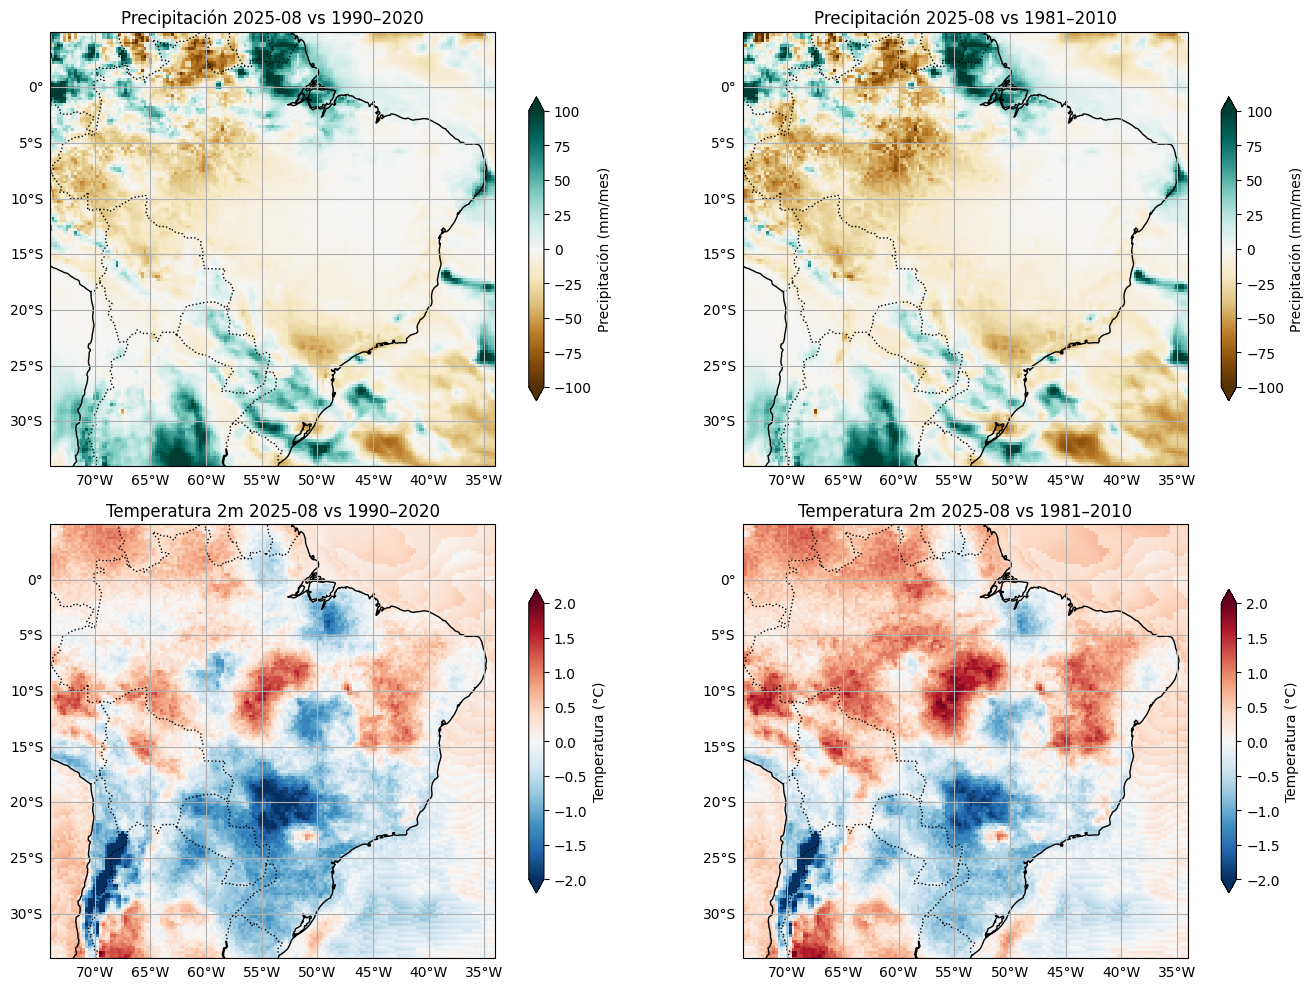

In [8]:
# ============================================
# 1. Instalar dependencias (solo en Colab)
# ============================================
#!apt-get install -y libproj-dev proj-data proj-bin libgeos-dev
!pip install -q cartopy xarray zarr fsspec requests

# ============================================
# 2. Importar librerías
# ============================================
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# ============================================
# 3. Definir fecha de análisis
# ============================================
fecha_analisis = "2025-08"   # AAAA-MM
anio, mes = fecha_analisis.split("-")
mes = int(mes)  # para climatologías

# ============================================
# 4. Abrir dataset ERA5 (requiere token en .netrc)
# ============================================
url = "https://data.earthdatahub.destine.eu/era5/reanalysis-era5-single-levels-monthly-means-v0.zarr"

ds = xr.open_dataset(
    url,
    engine="zarr",
    chunks="auto",
    storage_options={"client_kwargs": {"trust_env": True}}
)

# ============================================
# 5. Recorte geográfico (ejemplo: Sudamérica / país)
# ============================================
# Sudamérica completo
#lat_min, lat_max = -60, 15
#lon_min, lon_max = 270, 330   # (-90 a -30 en 0–360)

# Perú
#lat_min, lat_max = -20, 1
#lon_min, lon_max = 278, 292   # (-82 a -68)

# Colombia
#lat_min, lat_max = -5, 13
#lon_min, lon_max = 281, 294   # (-79 a -66)

# Ecuador
#lat_min, lat_max = -5, 2
#lon_min, lon_max = 279, 285   # (-81 a -75)

# Chile
#lat_min, lat_max = -55, -17
#lon_min, lon_max = 285, 293   # (-75 a -67)

# Argentina
#lat_min, lat_max = -55, -21
#lon_min, lon_max = 287, 307   # (-73 a -53)

# Brasil
lat_min, lat_max = -34, 5
lon_min, lon_max = 286, 326   # (-74 a -34)

# ============================================
# 6. Seleccionar variables
# ============================================
# Precipitación total (m → mm)
tp = ds["tp"] * 1000 *30
tp.attrs["units"] = "mm/mes"

# Temperatura 2m (K → °C)
t2m = ds["t2m"] - 273.15
t2m.attrs["units"] = "°C"

# Recortes
tp_sel  = tp.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
t2m_sel = t2m.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))

# ============================================
# 7. Seleccionar mes de análisis
# ============================================
tp_target  = tp_sel.sel(valid_time=fecha_analisis)
t2m_target = t2m_sel.sel(valid_time=fecha_analisis)

# ============================================
# 8. Climatologías
# ============================================
# Precipitación
clim_tp_1990_2020 = tp_sel.sel(valid_time=slice("1990-01", "2020-12"))
clim_tp_1990_2020_mes = clim_tp_1990_2020.sel(valid_time=clim_tp_1990_2020["valid_time"].dt.month == mes)
clim_tp_1990_2020_mean = clim_tp_1990_2020_mes.mean("valid_time")

clim_tp_1981_2010 = tp_sel.sel(valid_time=slice("1981-01", "2010-12"))
clim_tp_1981_2010_mes = clim_tp_1981_2010.sel(valid_time=clim_tp_1981_2010["valid_time"].dt.month == mes)
clim_tp_1981_2010_mean = clim_tp_1981_2010_mes.mean("valid_time")

# Temperatura
clim_t2m_1990_2020 = t2m_sel.sel(valid_time=slice("1990-01", "2020-12"))
clim_t2m_1990_2020_mes = clim_t2m_1990_2020.sel(valid_time=clim_t2m_1990_2020["valid_time"].dt.month == mes)
clim_t2m_1990_2020_mean = clim_t2m_1990_2020_mes.mean("valid_time")

clim_t2m_1981_2010 = t2m_sel.sel(valid_time=slice("1981-01", "2010-12"))
clim_t2m_1981_2010_mes = clim_t2m_1981_2010.sel(valid_time=clim_t2m_1981_2010["valid_time"].dt.month == mes)
clim_t2m_1981_2010_mean = clim_t2m_1981_2010_mes.mean("valid_time")

# ============================================
# 9. Anomalías
# ============================================
anom_tp_1990_2020  = tp_target  - clim_tp_1990_2020_mean
anom_tp_1981_2010  = tp_target  - clim_tp_1981_2010_mean
anom_t2m_1990_2020 = t2m_target - clim_t2m_1990_2020_mean
anom_t2m_1981_2010 = t2m_target - clim_t2m_1981_2010_mean

# ============================================
# 10. Graficar con Cartopy
# ============================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10),
                         subplot_kw={"projection": ccrs.PlateCarree()})

# Configuración común
for ax in axes.flat:
    ax.set_extent([lon_min-360, lon_max-360, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.coastlines(resolution="50m")
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.4)
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False

# Precipitación (BrBG, -100 a +100 mm/mes)
anom_tp_1990_2020.plot(
    ax=axes[0,0], transform=ccrs.PlateCarree(),
    cmap="BrBG", vmin=-100, vmax=100,
    cbar_kwargs={"label": "Precipitación (mm/mes)", "shrink": 0.7}
)
axes[0,0].set_title(f"Precipitación {fecha_analisis} vs 1990–2020")

anom_tp_1981_2010.plot(
    ax=axes[0,1], transform=ccrs.PlateCarree(),
    cmap="BrBG", vmin=-100, vmax=100,
    cbar_kwargs={"label": "Precipitación (mm/mes)", "shrink": 0.7}
)
axes[0,1].set_title(f"Precipitación {fecha_analisis} vs 1981–2010")

# Temperatura (RdBu_r, -2 a +2 °C)
anom_t2m_1990_2020.plot(
    ax=axes[1,0], transform=ccrs.PlateCarree(),
    cmap="RdBu_r", vmin=-2, vmax=2,
    cbar_kwargs={"label": "Temperatura (°C)", "shrink": 0.7}
)
axes[1,0].set_title(f"Temperatura 2m {fecha_analisis} vs 1990–2020")

anom_t2m_1981_2010.plot(
    ax=axes[1,1], transform=ccrs.PlateCarree(),
    cmap="RdBu_r", vmin=-2, vmax=2,
    cbar_kwargs={"label": "Temperatura (°C)", "shrink": 0.7}
)
axes[1,1].set_title(f"Temperatura 2m {fecha_analisis} vs 1981–2010")

plt.tight_layout()
plt.show()


Usando coordenadas: lat=-12, lon=-78 (convertido a 282)


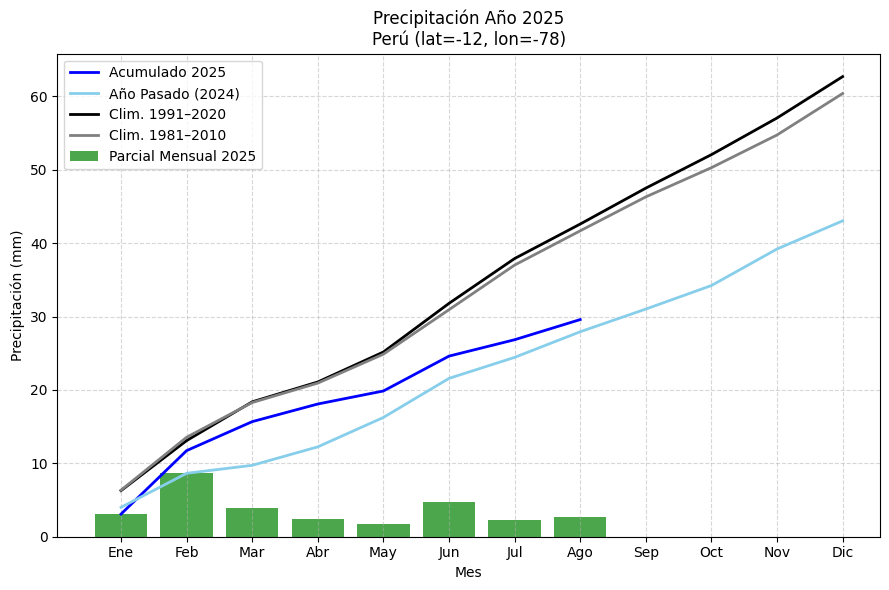

In [9]:
# ============================================
# Gráfico de precipitación mensual acumulada en un punto
# ============================================
import numpy as np
from geopy.geocoders import Nominatim

# Definir punto en grados clásicos (originales)
lat_in, lon_in = -12, -78

# Convertir longitud a sistema 0–360 para ERA5
if lon_in < 0:
    lon_punto = 360 + lon_in   # -80 → 280
else:
    lon_punto = lon_in
lat_punto = lat_in

print(f"Usando coordenadas: lat={lat_in}, lon={lon_in} (convertido a {lon_punto})")

# --------------------------------------------
# Identificar lugar con Geopy (si hay internet)
# --------------------------------------------
try:
    geolocator = Nominatim(user_agent="geoapi")
    location = geolocator.reverse((lat_in, lon_in), language="es")
    address = location.raw.get("address", {})

    # Orden de prioridad para mostrar
    lugar = (
        address.get("city") or
        address.get("town") or
        address.get("village") or
        address.get("county") or
        address.get("state_district") or
        address.get("state")
    )
    pais = address.get("country")
    lugar_str = f"{lugar}, {pais}" if lugar else pais
except Exception as e:
    print("No se pudo identificar el lugar:", e)
    lugar_str = "Ubicación desconocida"

# Extraer series en el punto
tp_punto = tp.sel(latitude=lat_punto, longitude=lon_punto, method="nearest")

# Convertir a DataFrame
df = tp_punto.to_dataframe().reset_index()
df["año"] = df["valid_time"].dt.year
df["mes"] = df["valid_time"].dt.month

# ============================================
# Años actual y pasado
# ============================================
anio_actual = 2025
anio_pasado = 2024

df_actual = df[df["año"] == anio_actual].groupby("mes")["tp"].mean()
df_pasado = df[df["año"] == anio_pasado].groupby("mes")["tp"].mean()

# ============================================
# Climatologías
# ============================================
df_1981_2010 = df[(df["año"] >= 1981) & (df["año"] <= 2010)].groupby("mes")["tp"].mean()
df_1991_2020 = df[(df["año"] >= 1991) & (df["año"] <= 2020)].groupby("mes")["tp"].mean()

# ============================================
# Calcular acumulados
# ============================================
acum_actual = df_actual.cumsum()
acum_pasado = df_pasado.cumsum()
acum_1981_2010 = df_1981_2010.cumsum()
acum_1991_2020 = df_1991_2020.cumsum()

# ============================================
# Gráfico estilo Valdivia
# ============================================
fig, ax = plt.subplots(figsize=(9,6))

# Barras: precipitación mensual parcial 2025
ax.bar(df_actual.index, df_actual.values, color="green", alpha=0.7, label="Parcial Mensual 2025")

# Líneas: acumulados
ax.plot(acum_actual.index, acum_actual.values, color="blue", linewidth=2, label="Acumulado 2025")
ax.plot(acum_pasado.index, acum_pasado.values, color="skyblue", linewidth=2, label="Año Pasado (2024)")
ax.plot(acum_1991_2020.index, acum_1991_2020.values, color="black", linewidth=2, label="Clim. 1991–2020")
ax.plot(acum_1981_2010.index, acum_1981_2010.values, color="gray", linewidth=2, label="Clim. 1981–2010")

# Estilo
ax.set_title(f"Precipitación Año {anio_actual}\n{lugar_str} (lat={lat_in}, lon={lon_in})")
ax.set_xlabel("Mes")
ax.set_ylabel("Precipitación (mm)")
ax.set_xticks(range(1,13))
ax.set_xticklabels(["Ene","Feb","Mar","Abr","May","Jun","Jul","Ago","Sep","Oct","Nov","Dic"])
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


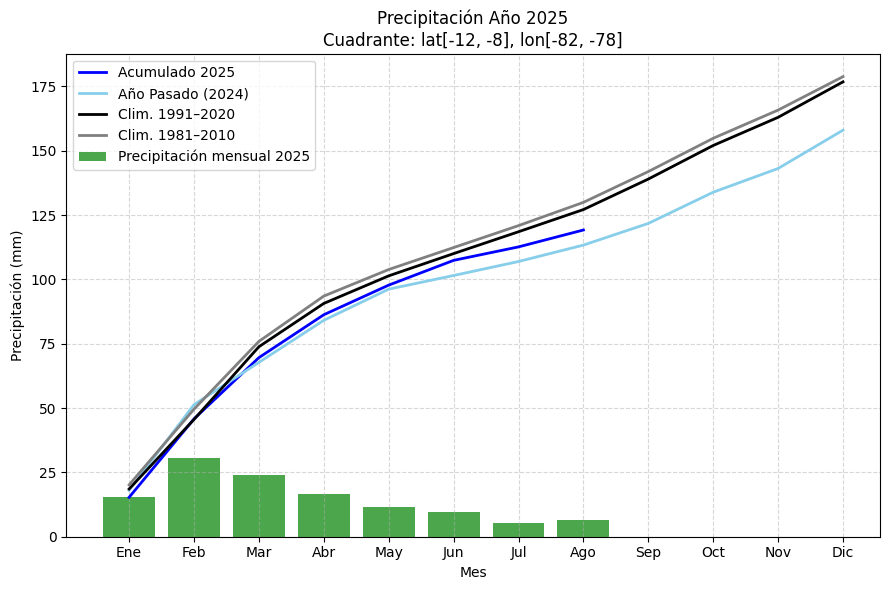

In [10]:
# ============================================
# Gráfico de precipitación mensual acumulada en un cuadrante
# ============================================
import numpy as np

# Definir cuadrante (ejemplo: Amazonía)
lat_min, lat_max = -12, -8
lon_min, lon_max = -82, -78   # en -180 a 180

# Convertir longitudes a 0–360 para ERA5
if lon_min < 0: lon_min = 360 + lon_min
if lon_max < 0: lon_max = 360 + lon_max

# Extraer serie promedio en el cuadrante
tp_quad = tp.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
tp_quad_mean = tp_quad.mean(dim=["latitude","longitude"])

# Convertir a DataFrame
df = tp_quad_mean.to_dataframe().reset_index()
df["año"] = df["valid_time"].dt.year
df["mes"] = df["valid_time"].dt.month

# ============================================
# Años actual y pasado
# ============================================
anio_actual = 2025
anio_pasado = 2024

df_actual = df[df["año"] == anio_actual].groupby("mes")["tp"].mean()
df_pasado = df[df["año"] == anio_pasado].groupby("mes")["tp"].mean()

# ============================================
# Climatologías
# ============================================
df_1981_2010 = df[(df["año"] >= 1981) & (df["año"] <= 2010)].groupby("mes")["tp"].mean()
df_1991_2020 = df[(df["año"] >= 1991) & (df["año"] <= 2020)].groupby("mes")["tp"].mean()

# ============================================
# Calcular acumulados
# ============================================
acum_actual = df_actual.cumsum()
acum_pasado = df_pasado.cumsum()
acum_1981_2010 = df_1981_2010.cumsum()
acum_1991_2020 = df_1991_2020.cumsum()

# ============================================
# Gráfico estilo Valdivia (pero para cuadrante)
# ============================================
fig, ax = plt.subplots(figsize=(9,6))

# Barras: precipitación mensual parcial 2025
ax.bar(df_actual.index, df_actual.values, color="green", alpha=0.7, label="Precipitación mensual 2025")

# Líneas: acumulados
ax.plot(acum_actual.index, acum_actual.values, color="blue", linewidth=2, label="Acumulado 2025")
ax.plot(acum_pasado.index, acum_pasado.values, color="skyblue", linewidth=2, label="Año Pasado (2024)")
ax.plot(acum_1991_2020.index, acum_1991_2020.values, color="black", linewidth=2, label="Clim. 1991–2020")
ax.plot(acum_1981_2010.index, acum_1981_2010.values, color="gray", linewidth=2, label="Clim. 1981–2010")

# Estilo
ax.set_title(f"Precipitación Año {anio_actual}\nCuadrante: lat[{lat_min-360 if lat_min>180 else lat_min}, {lat_max}], lon[{lon_min-360 if lon_min>180 else lon_min}, {lon_max-360 if lon_max>180 else lon_max}]")
ax.set_xlabel("Mes")
ax.set_ylabel("Precipitación (mm)")
ax.set_xticks(range(1,13))
ax.set_xticklabels(["Ene","Feb","Mar","Abr","May","Jun","Jul","Ago","Sep","Oct","Nov","Dic"])
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()
